In [10]:
!pip install lightgbm
#!brew install lightgbm

You should consider upgrading via the 'c:\users\cih46\appdata\local\programs\python\python35\python.exe -m pip install --upgrade pip' command.


In [22]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")

In [3]:
## Add Your Function Here

# 21.01.13 
# Writer : Jangmin
# Return df with new column['theta']
# theta -> starts from 1 to N (N is number of rows which TARGET is not 0 per Day)
def create_theta_column(df):
  df.insert(3, 'theta', 0)
  tmp = pd.DataFrame()
  for i in range(len(df)//48):
    train_tmp = df[df['TARGET'] > 0][df['Day']==i]
    sun_rise = train_tmp.index.tolist()[0] # sunrise
    sun_set = train_tmp.index.tolist()[-1] # sunset
    train_tmp = df.loc[df['Day']==i]
    train_tmp.loc[df['TARGET'] >0, 'theta'] = range(1, sun_set- sun_rise+2)
    tmp = tmp.append(train_tmp)
  return tmp

# 21.01.15 
# Writer : Sungin
def addTheta(df):
  df['Daytime'] = 0
  df['zenith'] = 90
  sunsetTime = 0
  sunriseTime = 0
  for i,row in df.iterrows():  
    if i!=0:
      if row['TARGET']>0 and df.iloc[i-1]['TARGET'] <= 0:
        sunriseTime = i
      if df.iloc[i-1]['TARGET']>0 and row['TARGET'] <= 0: 
        sunsetTime = i
    if i%48==47:
      for j in range(sunriseTime, sunsetTime):
        df.loc[j,'Daytime'] = sunsetTime-sunriseTime
        #df.loc[j,'zenith'] = abs(90 - 180 / (sunsetTime - sunriseTime) * ((j-sunriseTime)% 48))
  del df['zenith']
  return df
def addGHI(df):
  GHI= df['DNI'] * df['zenith'].apply(lambda x: math.cos(x * np.pi / 180)) + df['DHI']
  df['GHI'] = GHI
  return df

# 21.01.15
# Writer : Yelin
def create_GHI_feats(data,make_Elevation,make_Zenith,make_GHI):
    assert data.shape[0]%48==0
    total_day = (int)(data.shape[0]/48)
    Elevation = np.zeros((data.shape[0],1))
    Zenith= np.zeros((data.shape[0],1))
    GHI = np.zeros((data.shape[0],1))
    
    for i in range(total_day):
        day = data.iloc[i*48:i*48+48]
        sunrise = False
        sunset = False
        times = []
        
        # get sunrise and sunset time
        for j in range(48):
            if(not sunrise and day[j:j+1]['TARGET'].values>0):
                times.append(j)
                sunrise = True
            if(sunrise and not sunset and day[j:j+1]['TARGET'].values==0):
                times.append(j)
                sunset = True
                
        # check if times list has a problem
        if(len(times)!=2):
            print(times)

        daytime = times[1]-times[0]
        idx = 0
        for j in range(0,times[0]):
            Zenith[i*48+j] = 90
            
        for j in range(times[0],times[1]):
            Elevation[i*48+j] = idx*(180/daytime)
            Zenith[i*48+j] = np.abs(90 - Elevation[i*48+j])
            idx = idx + 1
            
        for j in range(times[1],48):
            Zenith[i*48+j] = 90
    
    if make_Zenith:
        data['Zenith'] = Zenith
        
    if make_Elevation:
        data['Elevation'] = Elevation
        
    if make_GHI:

        # Why for loop uses less memory than data['DNI']*np.cos(Zenith * np.pi/ 180) + data['DHI']
        for i in range(data.shape[0]):
            GHI[i] = data['DNI'][i]*np.cos(Zenith[i] * np.pi/180 ) + data['DHI'][i]
        data['GHI'] = GHI
        data[data['GHI']<0][['GHI']] = 0

    return data

# 21.01.14
# Writer : Sunghyun
def makeBefDiffFeature(featrue,data,shift_val):
    
    shift_val = int(shift_val)
    feature_bef = data[featrue].shift(shift_val).fillna(method='bfill')
    data[featrue+'_bef'+str(shift_val)] = data[featrue] - feature_bef

    return data



# 21.01.16
# Writer : Yelin
def create_is_raining_feats(data):
    assert data.shape[0]%48==0
    total_day = (int)(data.shape[0]/48)
    IsRain = np.zeros((data.shape[0],1))
    IsRain = data['TARGET']*data['RH']
    data['IsRain'] = IsRain
    del IsRain
    return data


# 21.01.18
# Writer : Joonhan
def create_season_feats(data):
    assert data.shape[0]%48==0
    total_day = (int)(data.shape[0]/48)
    temp = data.copy()
    
    season = np.zeros((data.shape[0],1))
    high_time = np.zeros((data.shape[0],1))
    for i in range(total_day):
        day = temp.iloc[i*48:i*48+48]
        #max_target2 = day['TARGET'].max()
        max_row = temp.loc[day['TARGET'].idxmax()]
        max_target = max_row['TARGET']
        max_hour = max_row['Hour']
        if(max_target<60):
            season[i] = 1
        elif(max_target>80):
            season[i] = 3
        else:
            if(max_hour<12):
                season[i] = 2
            else:
                season[i] = 4
        temp['Season'] = season
    
    return temp
        
# 21.01.20
# Writer: SungIn

def time_split(row):
    x= row['Hour']
    y = '_'+ str(int(row['Daytime']))
    return str(int(x)) + y

# 21.01.20
# Writer: SungIn
def cat_time(df,is_train):
    f_  = 'time_cat'
    features = []
    df[f_] = df.apply(time_split,axis=1)
    feature = df.groupby([f_])['TARGET'].agg([('target_mean','mean')]).reset_index()
    features.append(feature)
    feature = df.groupby([f_])['TARGET'].agg([('target_std','std')]).reset_index()    
    features.append(feature)
    feature = df.groupby([f_])['GHI'].agg([('GHI_mean','mean')]).reset_index()
    features.append(feature)
    feature = df.groupby([f_])['GHI'].agg([('GHI_std','std')]).reset_index()    
    features.append(feature)
    for fs in features:
        df = pd.merge(df,fs, how='left', on=[f_])
    if is_train==TEST_VIS:
        return df
    #df = pd.get_dummies(df,columns=['Daytime'])
    
    del df['time_cat']
    
    return df

#21.01.21
#Writer : Sungin
def relu_cos(x):
    x = -1 * np.cos(x/12*np.pi)
    return max(0,x)
    
def cos_hour(data):
    data['Cos_hour'] = data['Hour'].apply(relu_cos)
    return data

#21.01.21
#Wrigter : Sunghyun
def hour_mean(data):
    hour_day_bef = data['TARGET'].shift(48).fillna(method='bfill')
    data['Target_hour_mean'] = (hour_day_bef+data['TARGET'])/2
    data['TARGET_bef'] = data['TARGET'] - data['TARGET'].shift(2).fillna(method='bfill')
    
    return data

In [4]:
# 21.01.16
# Writer : Yelin
# 21.01.20
# MOD : SungIn
TRAIN=1
VALID=2#To make X_valid(day4)
TEST=3 #To make X_test
TEST_VIS=4 #for test_data visualization
def preprocess_data(data,feats_to_add,is_train=TRAIN):
    feats_basic = ['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']

    if is_train!=TEST_VIS:        
        data = data[feats_basic]
    
    ZEG = [False,False,False] # Zenith,Elevation,GHI
    ADG = [False,False,False] # Aggr, Daytime, GHI
    for feature in feats_to_add:
            if feature in feats_basic:
                continue
            elif feature=='Zenith':
                ZEG[0] = True
            elif feature=='Elevation':
                ZEG[1] = True
            elif feature=='GHI':
                ZEG[2] = True
                ADG[2] = True
            elif feature=='theta':
                data = create_theta_column(data)
            elif feature=='IsRain':
                data = create_is_raining_feats(data)
            elif feature=='Season':
                data = create_season_feats(data)
            elif feature=='Aggr':
                ADG[0] = True
            elif feature=='Daytime':
                data = addTheta(data)
                ADG[1] = True
            elif feature[:4]=='bef_':
                data = makeBefDiffFeature(feature.split('_')[-2],data,feature.split('_')[-1])
            elif feature=='TARGET_Hour_mean' :
                data = hour_mean(data)
            elif feature=='':
                continue
            elif feature=='Cos_hour':
                data = cos_hour(data)
            elif feature=='radian_Zenith':
                continue
            else:
                print("Can't make",feature)
                assert False
        
    if ZEG[0] or ZEG[1] or ZEG[2]:
        data = create_GHI_feats(data,ZEG[0],ZEG[1],ZEG[2])
        
    if ADG[0] and ADG[1] and ADG[2]:
        data = cat_time(data,is_train)     
   
    #basic feature select
    for basic in feats_basic :
        if basic not in feats_to_add :
            data = data.drop(basic,axis=1)

    if 'radian_Zenith' in feats_to_add :
        data['radian_Zenith'] = np.radians(data['Zenith'])
    
            
    if is_train==VALID:
        data_4 = data[data['Day']==4].sort_index().reset_index()
        data_5 = data[data['Day']==5].sort_index().reset_index()
        data_6 = data[data['Day']==6].sort_index().reset_index()

        data_4['Target1'] = data_5['TARGET']
        data_4['Target2'] = data_6['TARGET']
        del data_4['Day']
        del data_4['index']
        return data_4
    
    if is_train==TEST_VIS:
        return data
        
    if is_train==TRAIN:                
        data['Target1'] = data['TARGET'].shift(-48).fillna(method='ffill')
        data['Target2'] = data['TARGET'].shift(-48*2).fillna(method='ffill')
        data = data.dropna()
            
        del data['Day']
        
        #print('train',data.keys())    

        return data.iloc[:-96]
    
    
    elif is_train==TEST:
        data = data[data['Day']==6].sort_index()
        del data['Day']
        
        #print('test',data.keys())    

        return data

In [20]:
## Training code        
from lightgbm import LGBMRegressor,plot_importance
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor( objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027)                   
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=0)
    
    #fig,ax = plt.subplots(figsize=(10,6))
    #plot_importance(model,ax=ax)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model


def compute_quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    return np.maximum(quantile * residual, (quantile - 1) * residual)

# Target 예측
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):
    
    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()
    
    sum_best_score = 0
    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)
        #print(model.best_score_['valid_0']['quantile'])
        sum_best_score = sum_best_score + model.best_score_['valid_0']['quantile']

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred, sum_best_score/9

In [13]:
## add feature name to use
## 'Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T' -> default use

# Hour - 시간
# Minute - 분
# DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
# DNI - 직달일사량(Direct Normal Irradiance (W/m2))
# WS - 풍속(Wind Speed (m/s))
# RH - 상대습도(Relative Humidity (%))
# T - 기온(Temperature (Degree C))
# Target - 태양광 발전량 (kW)

# 'theta', 'Hour_bef', 'IsRain', 'Zenith', 'Elevation','GHI', 'Season','Aggr','Daytime','RH_bef','Cos_hour','Target_hour_mean'
# 'Aggr' => 'GHI','Daytime' 모두 사용할 것
# GHI feature has a memory issue right now

In [14]:
# make train and test data

train = pd.read_csv('./data/train/train.csv')

submission = pd.read_csv('./data/sample_submission.csv')

'''
df_train = create_season_feats(train)
df_train = preprocess_data(train,feats_to_add)


df_test = []
test_bef = []
for i in range(81):
    file_path = '/kaggle/input/dacon/data/test/'  + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = create_season_feats(temp)
    temp1 = preprocess_data(temp,feats_to_add,is_train=False)
    df_test.append(temp1)
    temp2 = preprocess_data(temp,feats_to_add)[-48:]
    test_bef.append(temp2)

X_test = pd.concat(df_test)
X_valid = pd.concat(test_bef)
assert df_train.shape[1]-2==X_test.shape[1]
'''

"\ndf_train = create_season_feats(train)\ndf_train = preprocess_data(train,feats_to_add)\n\n\ndf_test = []\ntest_bef = []\nfor i in range(81):\n    file_path = '/kaggle/input/dacon/data/test/'  + str(i) + '.csv'\n    temp = pd.read_csv(file_path)\n    temp = create_season_feats(temp)\n    temp1 = preprocess_data(temp,feats_to_add,is_train=False)\n    df_test.append(temp1)\n    temp2 = preprocess_data(temp,feats_to_add)[-48:]\n    test_bef.append(temp2)\n\nX_test = pd.concat(df_test)\nX_valid = pd.concat(test_bef)\nassert df_train.shape[1]-2==X_test.shape[1]\n"

In [15]:
#!pip install tqdm

In [16]:
from itertools import combinations
from tqdm import tqdm
def make_checking_feature_list(feats_to_check,feats_to_add) :
    combi_list=['']
    combi_list.extend(feats_to_check.copy())

    for i in range(1,len(feats_to_check)) :
        combi_list.extend( list(combinations(feats_to_check,i+1)) )

    combi_list = map(lambda x : list(x) if type(x)==tuple else x,combi_list)

    # for c in combi_list:
    #     print(c)

    feature_list = []
    for feature in combi_list:
        add_feature = []
        add_feature.extend(feats_to_add)
        if type(feature)!= list :
            add_feature.append(feature)
        else:
            add_feature.extend(feature)
        feature_list.append(add_feature)
        
    return feature_list

In [23]:
# 21.01.20
# Writer: SungIn

#test 6일치 data 모두 활용
#Aggregate func 사용

from sklearn.model_selection import train_test_split

#basic feature 또한 아래로 feats_to_check로 옮겨서 체크 가능
#Day 와 TARGET은 필수적으로 넣어줘야 에러없이 사용가능

#feats_basic = ['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']

feats_basic = ['Day','Hour','TARGET','WS','RH', 'T']
feats_to_add = ['Daytime','Aggr','GHI','bef_TARGET_2','bef_RH_2','bef_TARGET_48']

feats_to_add.extend(feats_basic)

#check할 feature 들을 입력하면 가능한 모든 조합을 생성하여, feats_to_add에 추가하여 validation에서 가장 좋은 best_score 조합을 만듦
#체크 여부 사용하지 않고 기존처럼 사용하려면 [] 로 비워서 사용.
feats_to_check = ['Minute','Zenith','bef_GHI_2','Season','Elevation']
#feats_to_check = ['bef_RH_1','bef_WS_1','bef_RH_3','bef_WS_3','bef_T_2','bef_T_1']

for feature in feats_to_check:
    assert feature not in feats_to_add


feature_list = make_checking_feature_list(feats_to_check,feats_to_add)

result_dict = {}

result_1=[]
result_2=[]

for feats_to_test in tqdm(feature_list) :    

    df_train = preprocess_data(train,feats_to_test)
    tests= []
    for i in range(81):
        temp = pd.read_csv('./data/test/'  + str(i) + '.csv')
        temp['index'] = i
        tests.append(temp)
    tests = pd.concat(tests)
    tests = tests.reset_index()
    X_test = preprocess_data(tests,feats_to_test,is_train=TEST)
    X_valid = preprocess_data(tests,feats_to_test,is_train=VALID)
    tests = preprocess_data(tests,feats_to_test,is_train=TEST_VIS)
    assert df_train.shape[1]-2==X_test.shape[1]
    
    X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
    X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

    X_valid_1 = X_valid.iloc[:,:-2]
    X_valid_2 = X_valid.iloc[:,:-2]
    Y_valid_1 = X_valid.iloc[:,-2]
    Y_valid_2 = X_valid.iloc[:,-1]

    # Target1
    models_1, results_1, best_score_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)

    # Target2
    models_2, results_2,best_score_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
    
    best_score = (best_score_1 + best_score_2)/2
    
    result_dict[str(feats_to_test)] = best_score
    
    result_list = sorted(result_dict.items(),key=lambda x : x[1])
    
    print(result_list)
    
result_list = sorted(result_dict.items(),key=lambda x : x[1])

  0%|          | 0/1 [00:00<?, ?it/s]0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction

In [18]:
result_list

[("['Zenith', 'Elevation', 'Season', 'Daytime', 'Aggr', 'GHI', 'bef_TARGET_2', 'bef_RH_2', 'bef_TARGET_48', 'Day', 'Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', '']",
  2.143072318093035)]

In [19]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values

str_ = ""
for feature in feats_to_add:
    str_ += feature[0]
    
#submission.to_csv('submission'+str_+'.csv', index=False)

In [13]:
# Below is a visualizaion 

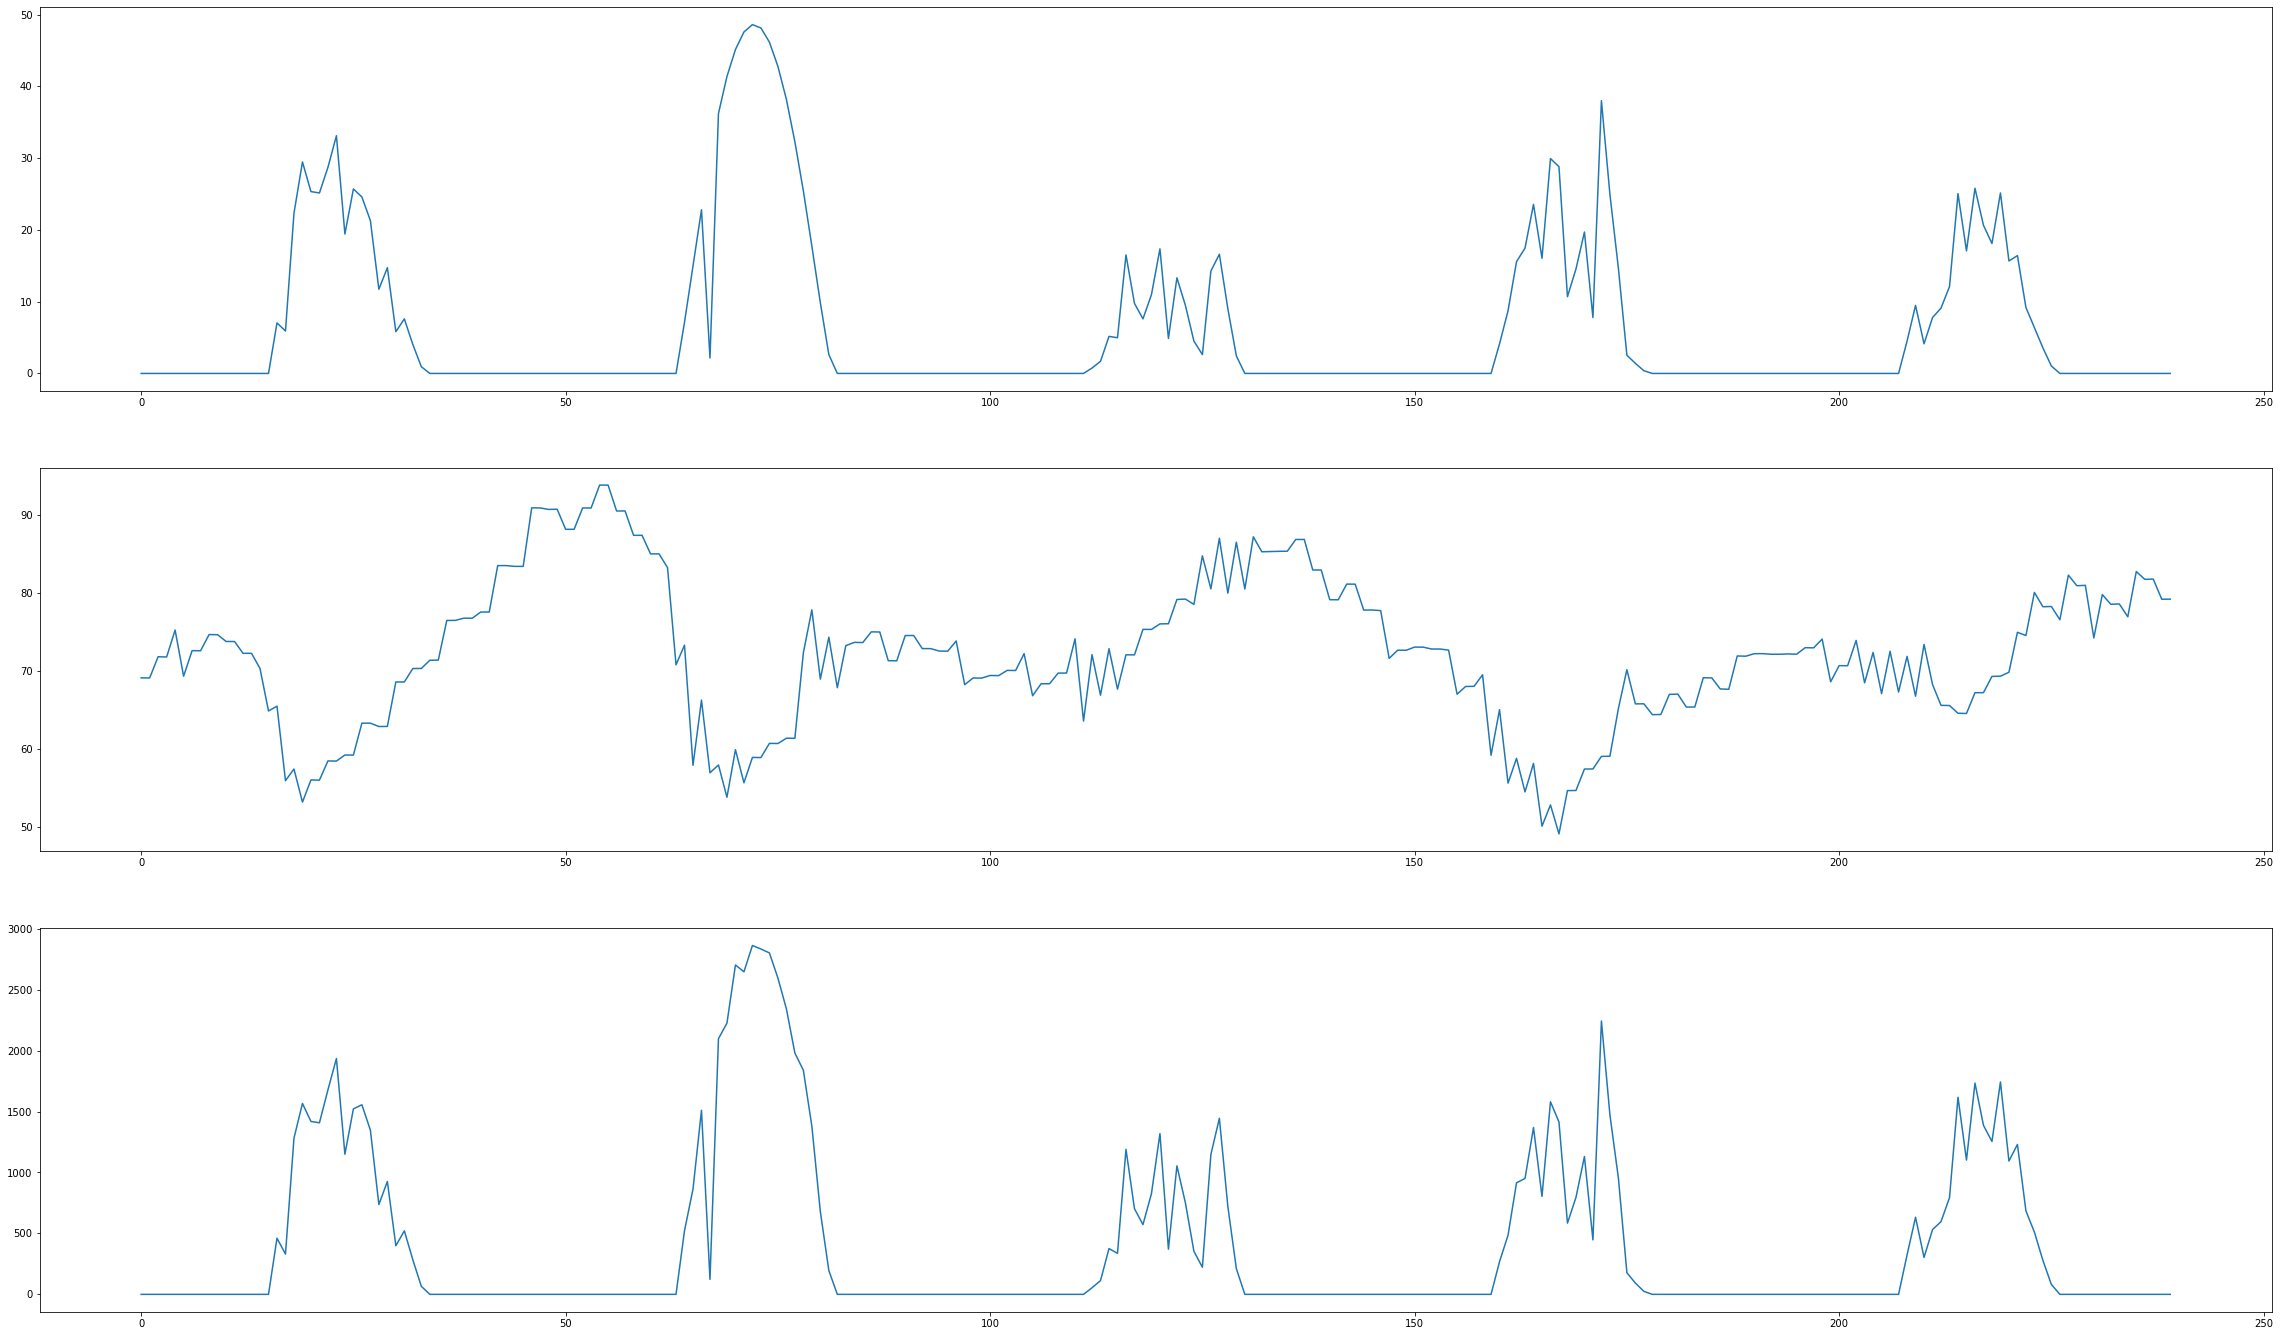

In [14]:
plt.figure(figsize=(40,24))
plt.subplot(3,1,1)
plt.plot(train['TARGET'][:48*5])
plt.subplot(3,1,2)
plt.plot(train['RH'][:48*5])
plt.subplot(3,1,3)
plt.plot(train['RH'][:48*5]*train['TARGET'][:48*5])

In [15]:
tests

,level_0,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,...,RH_bef2,TARGET_bef48,Zenith,Elevation,GHI,time_cat,target_mean,target_std,GHI_mean,GHI_std
0,0,0,0,0,0,0,2.7,34.42,0.0,0.0,...,0.00,0.0,90.0,0.0,0.0,0_0,0.0,0.0,0.0,0.0
1,1,0,0,30,0,0,2.7,34.17,0.1,0.0,...,-0.25,0.0,90.0,0.0,0.0,0_0,0.0,0.0,0.0,0.0
2,2,0,1,0,0,0,2.7,34.23,0.2,0.0,...,-0.19,0.0,90.0,0.0,0.0,1_0,0.0,0.0,0.0,0.0
3,3,0,1,30,0,0,2.7,33.99,0.3,0.0,...,-0.18,0.0,90.0,0.0,0.0,1_0,0.0,0.0,0.0,0.0
4,4,0,2,0,0,0,2.8,33.97,0.4,0.0,...,-0.26,0.0,90.0,0.0,0.0,2_0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27211,331,6,21,30,0,0,0.8,63.35,13.7,0.0,...,3.58,0.0,90.0,0.0,0.0,21_0,0.0,0.0,0.0,0.0
27212,332,6,22,0,0,0,0.7,64.82,13.1,0.0,...,3.48,0.0,90.0,0.0,0.0,22_0,0.0,0.0,0.0,0.0
27213,333,6,22,30,0,0,0.7,66.10,12.8,0.0,...,2.75,0.0,90.0,0.0,0.0,22_0,0.0,0.0,0.0,0.0
27214,334,6,23,0,0,0,0.6,67.64,12.4,0.0,...,2.82,0.0,90.0,0.0,0.0,23_0,0.0,0.0,0.0,0.0


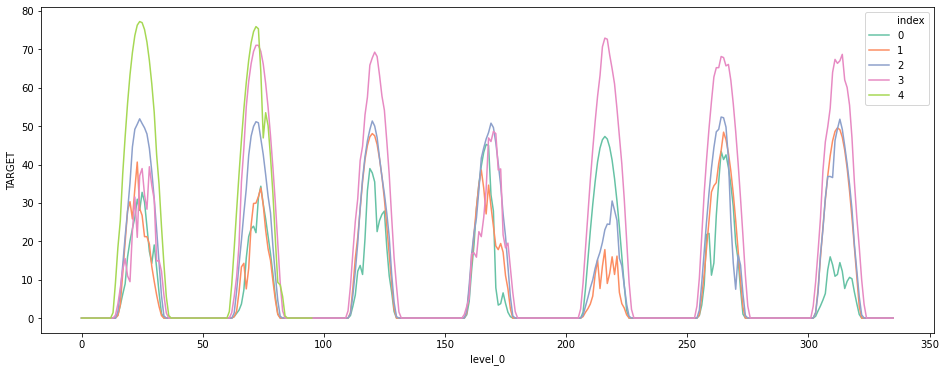

In [16]:
#Test Data 시각화

import seaborn as sns
plt.figure(figsize=(16, 6))
sns.lineplot(x='level_0',y='TARGET',hue='index',data=tests[:48*6*5], palette="Set2")

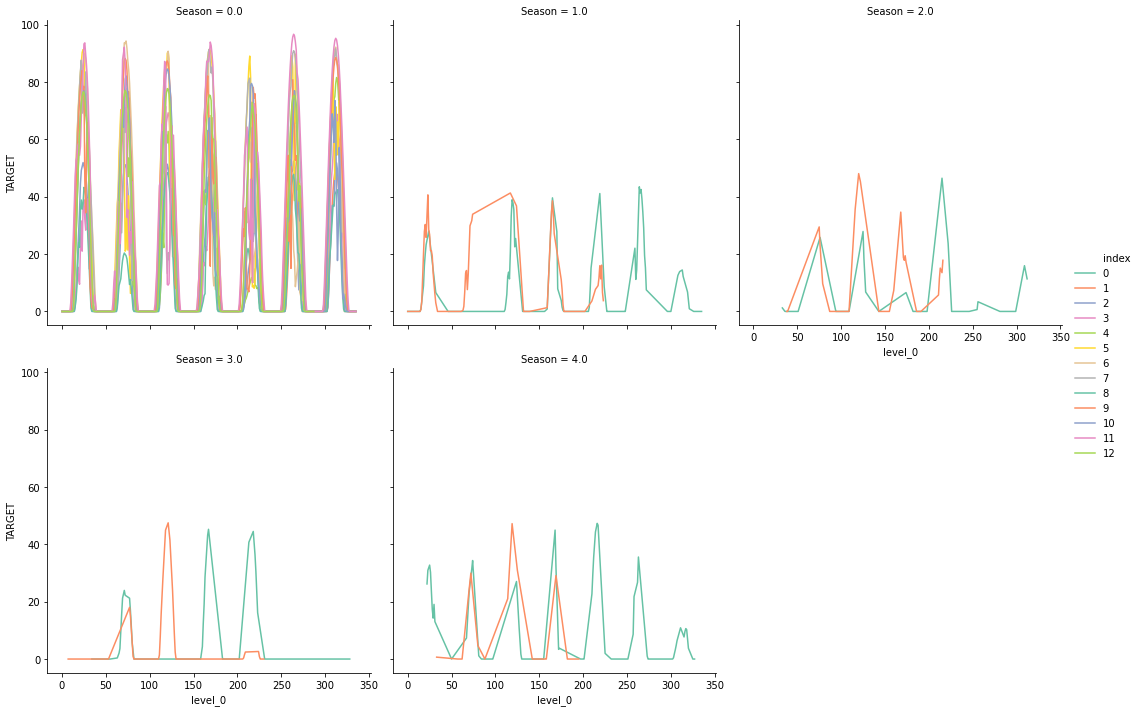

In [17]:
#Season 별 data 분포
sns.relplot(x='level_0',y='TARGET',hue='index',data=tests[:48*6*15],col_wrap=3, col='Season', palette="Set2",kind='line')

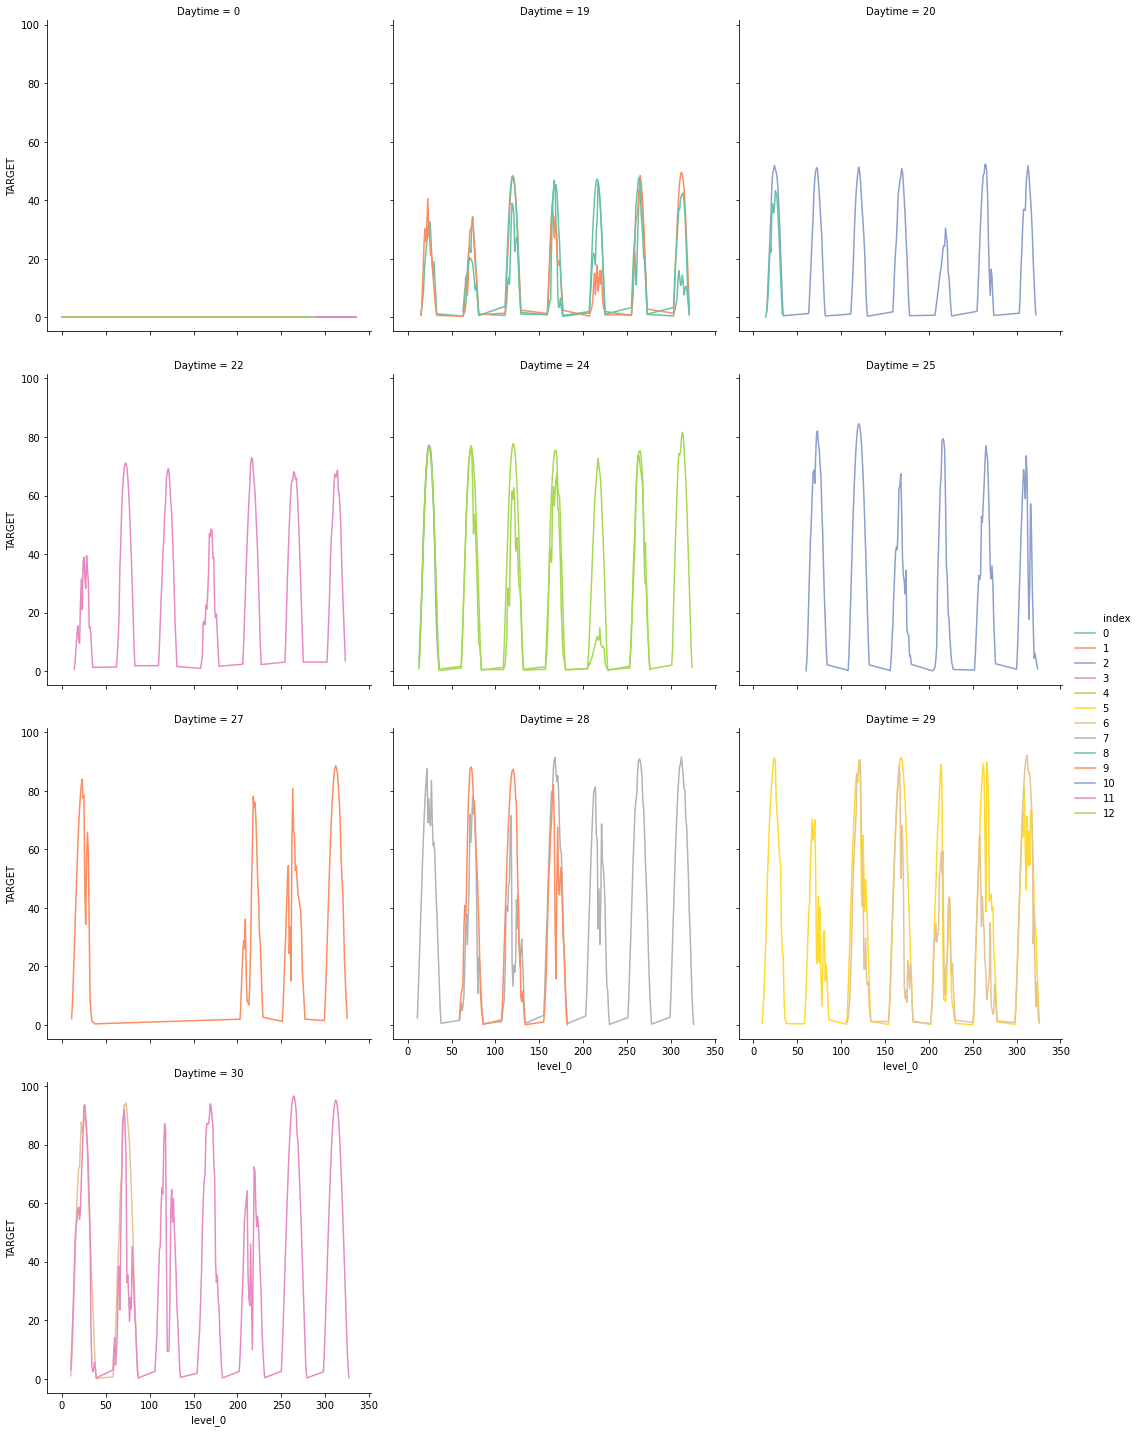

In [18]:
#Daytime 별 data 분포
sns.relplot(x='level_0',y='TARGET',hue='index',data=tests[:48*6*15],col_wrap=3, col='Daytime', palette="Set2",kind='line')

In [19]:
tests

,level_0,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,...,RH_bef2,TARGET_bef48,Zenith,Elevation,GHI,time_cat,target_mean,target_std,GHI_mean,GHI_std
0,0,0,0,0,0,0,2.7,34.42,0.0,0.0,...,0.00,0.0,90.0,0.0,0.0,0_0,0.0,0.0,0.0,0.0
1,1,0,0,30,0,0,2.7,34.17,0.1,0.0,...,-0.25,0.0,90.0,0.0,0.0,0_0,0.0,0.0,0.0,0.0
2,2,0,1,0,0,0,2.7,34.23,0.2,0.0,...,-0.19,0.0,90.0,0.0,0.0,1_0,0.0,0.0,0.0,0.0
3,3,0,1,30,0,0,2.7,33.99,0.3,0.0,...,-0.18,0.0,90.0,0.0,0.0,1_0,0.0,0.0,0.0,0.0
4,4,0,2,0,0,0,2.8,33.97,0.4,0.0,...,-0.26,0.0,90.0,0.0,0.0,2_0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27211,331,6,21,30,0,0,0.8,63.35,13.7,0.0,...,3.58,0.0,90.0,0.0,0.0,21_0,0.0,0.0,0.0,0.0
27212,332,6,22,0,0,0,0.7,64.82,13.1,0.0,...,3.48,0.0,90.0,0.0,0.0,22_0,0.0,0.0,0.0,0.0
27213,333,6,22,30,0,0,0.7,66.10,12.8,0.0,...,2.75,0.0,90.0,0.0,0.0,22_0,0.0,0.0,0.0,0.0
27214,334,6,23,0,0,0,0.6,67.64,12.4,0.0,...,2.82,0.0,90.0,0.0,0.0,23_0,0.0,0.0,0.0,0.0


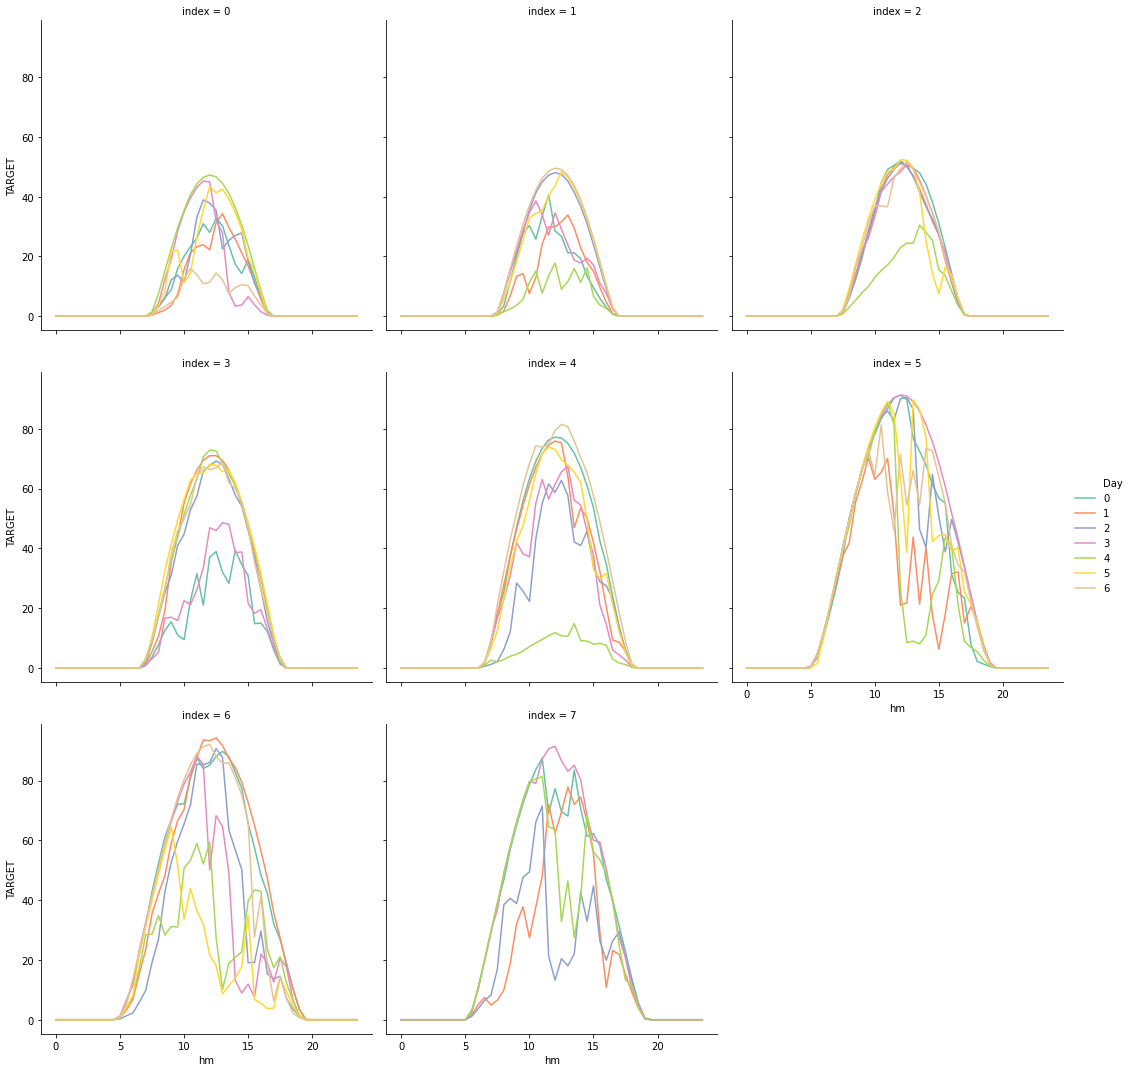

In [20]:
# Daytime 별 data 분포
tests['hm'] =tests['Hour'] + tests['Minute'] / 60
sns.relplot(x='hm',y='TARGET',hue='Day',data=tests[:48*6*9],col_wrap=3, col='index', palette="Set2",kind='line')

In [21]:
# 7일차 실제 예측값 plotting
#sns.lineplot(x='',y='TARGET',hue='index',data=X_valid, col='Daytime', palette="Set2",kind='line')

In [22]:
# 5일차 6일차 예측과 실제값(valid_set) 비교

# ver.15



## Validation Code 추가

4일째 Data -> 5일째 / 6일째 예측

실제 제출 결과와 같은 변화 양상을 보이는지 확인

Cf> test data 를 학습 시 사용하면 안됨 -> validation set으로도 사용 불가?(early stop 에 사용됨) -> 성능 더 높인 뒤, valid 변경 후 성능확인

> 결과

            None   HZt   HZtSIGE_full    HZtSIGE_0.7    HZEGSAD_d&h3  HZEGSAD_d&h1  HZEGSAD_GHI     HZEGSADR   ZESDACGTbbbDHTDDWRT   ZESDACGTbbbrDHTDDWRT
    제출    1.96   1.886   1.879           1.8748           1.868                                      1.838     
    val    2.33   2.245    2.234           2.231            2.179         2.158        2.154          2.149         2.1459                   2.1447
        
## Daytime & 시간 별로 Target,DNI,DHI,GHI Grouping(Aggr func.)


### Test Data Grouping
0. 6일치 데이터 활용하여 season 정보 파악

1. test data visualization


## Overfitting 가능성

-  Test data full vs. 0.7 성능비교

    -  0.7이 미세하지만 더 낮은 loss 를 보임

-  shuffle = True 시 비슷한 성능인 것으로 보아 training 후반부 데이터와 test 데이터와 연관도가 떨어질 가능성 존재
   -  Outlier나 연관도가 떨어지는 data 탐색, 제거 시 성능 증가 예상


### Q. 두 변수를 곱한 feature 를 생성하는 것은 의미가 있는가?
-  sup : 반비례 관계등을 표현하고자 할 때 유리한가? (ex. 습도-일사량(발전량) )

습도변화량 * TARGET 변화량 곱 feature 사용

> 변화 없음



# ver.16


## Unapplied
 
 1. Dart 사용 

> 긴 실행시간, loss 다소 증가.

# Applied

### 1. 시간 feature 주기화
Cos_Hour

    Hour만 제거 
    val 2.149
    
    Cos_Hour만 추가
    val 2.1478
    
    Hour, Cos_Hour 모두 사용
    val 2.149
    
    ReLU 추가
    val 2.147-> 2.1405
 
### 2. Daytime One-Hot Encoding 추가
 > val_loss 약간 감소
 
### 3. 2일간의 TARGET 평균치 추가
Target_Hour_mean

 > val_loss 변화 약간 감소****
 
### 4. Target_bef 생성 시 Hour_bef 제거
 > val_loss 변화 약간 감소

 
### Relu & OneHot & Time_hour_mean
    val    2.1405
    submit 1.8478611686
    
    only one-hot:
        val 2.147
    only relu: 
        val 2.149
    onehot&relu:
        val 2.148

In [23]:
#TODO : Feature Importance plotting